# 자동차 연비 예측

## 선형회귀

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

#데이터 전처리를 위해
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)


#출력값에 대한 고정을 위한 코드
#출력값을 소수점 셋째자리까지만 출력, 실수가 나오게 하기 위해 suppress=True로 고정.
np.set_printoptions(precision=3, suppress=True)

2.4.1


### 데이터 준비

In [5]:
#데이터 준비

url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'

#MPG : 연비가 얼마나 나가는지
#Cylinders : cc
#D : 배기량
#H : 마력
#W : ?
#A : 악셀에 대한
#Model Year : 모델 생산 년도
#Origin : ? 
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

#na_values: 결측치에 대한 코드
raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [6]:
dataset = raw_dataset.copy()  #원본 데이터 카피
dataset.tail()  #데이터의 끝 부분만 출력 / 앞 부분은 헤드를 쓰면 됨

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


### 데이터 전처리

In [7]:
#결측값을 없애기 위한 전처리 과정

#결측값 확인
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [8]:
#결측값 제거

dataset = dataset.dropna()

In [9]:
#The "Origin" column is really categorical, not numeric. So convert that to a one-hot with pd.get_dummies:
#범주형이라 원-핫 인코딩이 필요

#테이블 경우 수치형인지 범주형인지 파악을 먼저 해야 함.
#수치형은 모델에 그냥 넣을 수 있지만 범주형은 안됨.
#국가 이름을 숫자로 대체한 것

dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [10]:
#더미의 가변수 만들기 = get_dummies
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


In [11]:
#train과 test를 8:2로 분리
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [12]:
test_dataset.shape

(78, 10)

In [13]:
train_dataset.shape

(314, 10)

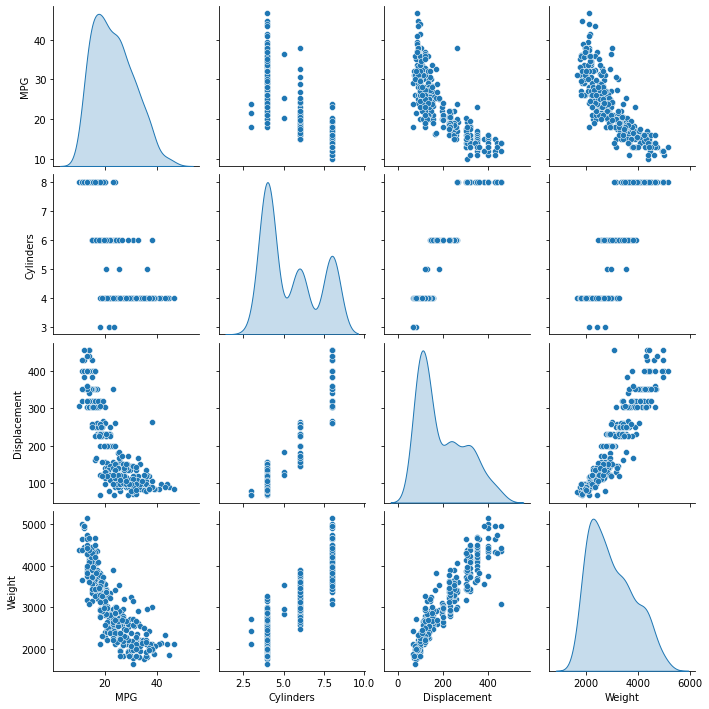

In [14]:
#데이터 시각화
#diag_kind= 로 그래프 모양을 바꿀 수 있음.

sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

In [15]:
#전체적인 통계 보기

#transpose로 행과 렬을 바꿈
#describe는 전반적인 통계를 볼 수 있음.

train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


In [16]:
#평균, 표준편차 보기

#feature, label 분리
train_features = train_dataset.copy()
test_features = test_dataset.copy()

#pop을 이용해서 MPG 라벨을 제거
#피쳐만 가지고 모델을 돌릴 수 있게끔(?
train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

In [17]:
#표준화 작업
#위에서와 같이 전반적인 통계를 보는 것

#원핫인코딩은 정규와 필요가 없지만 간소화를 위해 모든 피쳐에 대해 정규화 함.

train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Europe,0.178344,0.383413
Japan,0.197452,0.398712
USA,0.624204,0.485101


### 모델학습

In [19]:
#normalizer layer
normalizer = preprocessing.Normalization(axis =1 )

In [20]:
#모든 칼럼의 스케일을 맞출 수 있음
normalizer.adapt(np.array(train_features))

In [21]:
#평균과 분산이 계산되어 레이어에 저장
print(normalizer.mean.numpy())

[   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
    0.624]


In [23]:
first = np.array(train_features[:1])

with np.printoptions(precision = 2, suppress = True) :
    print('First example :', first)
    print()
    print('Normalized:', normalizer(first).numpy())

First example : [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


In [24]:
#모델 학습

#선형회귀
horsepower = np.array(train_features['Horsepower'])

horsepower_normalizer = preprocessing.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)

In [25]:
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)   #하나의 덴스 : 즉 선형회귀를 의미
])

horsepower_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [26]:
#훈련 전 모델의 10개 값만 넣고 shape만 확인
horsepower_model.predict(horsepower[:10])

array([[ 0.706],
       [ 0.399],
       [-1.303],
       [ 0.989],
       [ 0.895],
       [ 0.351],
       [ 1.06 ],
       [ 0.895],
       [ 0.233],
       [ 0.399]], dtype=float32)

In [27]:
horsepower_model.compile(optimizer = tf.optimizers.Adam(learning_rate = 0.1),
                        loss = 'mean_absolute_error')

In [31]:
%%time

history = horsepower_model.fit(
    train_features['Horsepower'], train_labels, epochs = 100, verbose=0,
    validation_split = 0.2
)

CPU times: user 8.01 s, sys: 667 ms, total: 8.68 s
Wall time: 6.93 s


In [32]:
#모델 훈련 결과

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.804066,4.185915,95
96,3.811134,4.211160,96
97,3.806017,4.180544,97
98,3.804953,4.168253,98
99,3.807295,4.194407,99


In [33]:
hist.head()

,loss,val_loss,epoch
0,22.867413,22.932152,0
1,22.064762,22.132475,1
2,21.262297,21.332346,2
3,20.465097,20.532637,3
4,19.661860,19.732519,4


In [34]:
#시각화 하기

#history.history에서 loss와 val_loss 비교를 위한 시각화
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

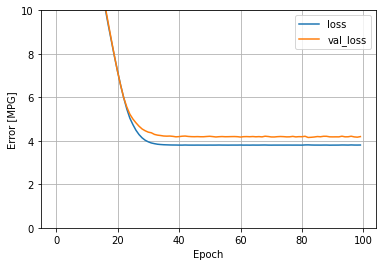

In [35]:
plot_loss(history)

In [37]:
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=0)

test_results

{'horsepower_model': 3.6354033946990967}

In [38]:
#피쳐와 데이터의 분포 시각화

x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

In [39]:
def plot_horsepower(x, y):
  plt.scatter(train_features['Horsepower'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

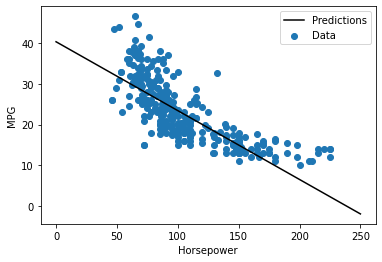

In [40]:
plot_horsepower(x,y)

### 전체 피쳐를 넣고 분석

In [41]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [42]:
linear_model.predict(train_features[:10])

array([[-2.097],
       [ 0.313],
       [ 2.134],
       [-1.082],
       [-2.464],
       [ 1.042],
       [-2.527],
       [ 2.533],
       [ 0.227],
       [-2.697]], dtype=float32)

In [43]:
linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[ 0.407],
       [ 0.17 ],
       [ 0.768],
       [ 0.615],
       [ 0.767],
       [ 0.54 ],
       [ 0.55 ],
       [-0.647],
       [ 0.219]], dtype=float32)>

In [44]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [45]:
%%time

history = linear_model.fit(
    train_features, train_labels, 
    epochs=100,
    verbose=0,  #정확도나 loss를 표시해주는 것.
    validation_split = 0.2  
)

CPU times: user 7.93 s, sys: 701 ms, total: 8.63 s
Wall time: 6.89 s


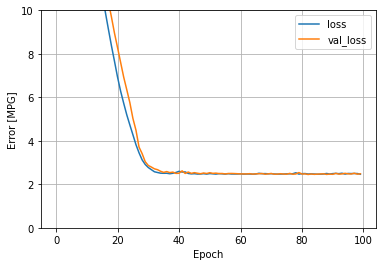

In [46]:
plot_loss(history)

In [48]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

test_results['linear_model']

2.5152947902679443

## DNN(Deep Nural Netwark)

In [49]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm, #정규화 한 걸 받아서 레이어를 쌓음
      layers.Dense(64, activation='relu'), #활성화 함수를 사용했기에 비선형으로 나올 수 있던 것
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [50]:
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

In [52]:
dnn_horsepower_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [53]:
%%time
history = dnn_horsepower_model.fit(
    train_features['Horsepower'], train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 8.82 s, sys: 516 ms, total: 9.33 s
Wall time: 7.48 s


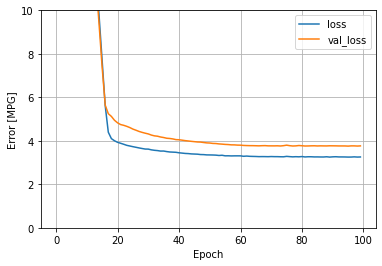

In [54]:
plot_loss(history)

In [55]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

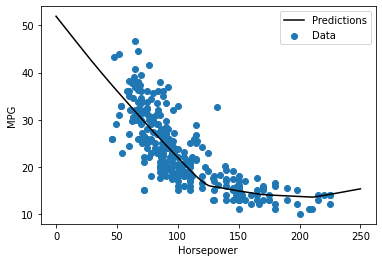

In [56]:
plot_horsepower(x, y)

In [57]:
#test dataset으로 모델 예측

test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['Horsepower'], test_labels,
    verbose=0)

In [58]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 9)                 19        
_________________________________________________________________
dense_5 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [59]:
%%time
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 8.41 s, sys: 626 ms, total: 9.04 s
Wall time: 7.23 s


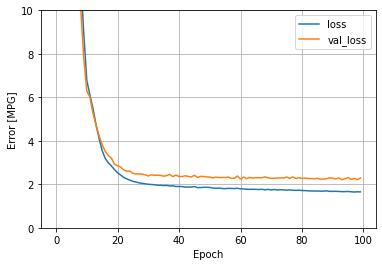

In [60]:
plot_loss(history)

In [61]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

test_results['dnn_model']

1.732249140739441

In [62]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.635403
linear_model,2.515295
dnn_horsepower_model,2.917349
dnn_model,1.732249


- Mean absolute error
  -  실제 값과 인풋값의 에러에 절대값을 취한 뒤 sum하여 평균을 한 듯
  -  아래랑 비교했을 때 비교적 이상치의 영향을 덜 받는

- Mean Squared Error
  -  에러에 제곱을 하여 sum 후 평균을 취한 

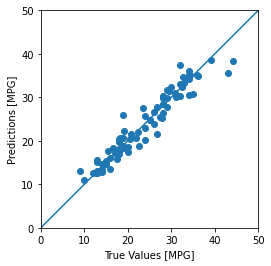

In [63]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

- 점과 직선이 일치하면 예측 값과 실제 값이 같음 
- 두개가 가까워야 예측을 잘 한 것

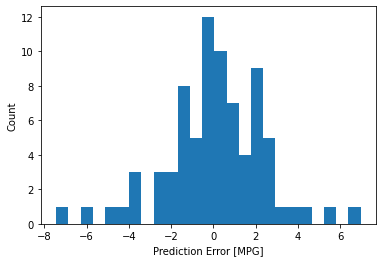

In [64]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

In [65]:
#모델 저장
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model/assets


In [70]:
#저장한 모델 다시 불러오기
reloaded = tf.keras.models.load_model('dnn_model')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

test_results['reloaded']

1.732249140739441

In [71]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.635403
linear_model,2.515295
dnn_horsepower_model,2.917349
dnn_model,1.732249
reloaded,1.732249
